In [1]:
import numpy as np

from pyquil import Program
from pyquil.paulis import *
from pyquil.api import WavefunctionSimulator
from pyquil.gates import *

from scipy.optimize import minimize
import matplotlib
import matplotlib
import matplotlib.pyplot as plt

In [5]:
num_cities = 3

distance_matrix = np.matrix([[0.0, 3.0, 5.0],
 [3.0, 0.0, 4.0],
 [5.0, 4.0, 0.0]
 ])

p = 3

weight1 = 200
weight2 = 80

In [6]:
sim = WavefunctionSimulator()

In [7]:
def prepare_initial_state():
    pq = Program()
    for i in range(0, num_cities**2):
        pq += Program(H(i))
    return pq

In [8]:
def penalize_distances():
	ps = sI()
	for i in range(0, num_cities):
		for j in range(i, num_cities):
			for t in range(0, num_cities - 1):
				wij =  - (distance_matrix.item((i, j))) / 2
				q1 = t * num_cities + i
				q2 = t * num_cities + j
				ps += (wij * sI() - wij * sZ(q1) * sZ(q2))
	return ps


def penalize_multiple_locations():
	ps = sI()
	for t in range(num_cities):
		binary_representation = list(range(t * num_cities, (t + 1) * num_cities))
		ps += penalize_range(binary_representation)
	return ps

def penalize_repeated_locations():
	ps = sI()
	for i in range(num_cities):
		occurances_of_i = list(range(i, num_cities**2, num_cities))
		ps += penalize_range(occurances_of_i)
	return ps

def penalize_range(must_be_single_one: list):
	print("Must have a single 1: {}".format(must_be_single_one))
	i_terms = sI()
	z_terms = sI()
	mixed_terms = sI()
	for qubit in must_be_single_one:
		i_terms = i_terms * sI(qubit)
		z_terms = z_terms * sZ(qubit)
		mixed_terms = mixed_terms * (sI(qubit) - sZ(qubit))
	punishment = weight1 * (i_terms + z_terms) + weight2 * mixed_terms

	return punishment


def prepare_cost():
	return penalize_distances() + penalize_repeated_locations() + penalize_multiple_locations()


In [9]:
# PauliSum Exponentiation from https://github.com/rigetti/pyquil/commit/785a5a549ce45da054369351032fb9ec826fdf70
def prepare_exponential(ps: PauliSum):
	fns = [exponential_map(term) for term in ps]
	def exp(param):
		return sum([f(param) for f in fns], Program())
	return exp

def parameterized_quantum_state(h_cost, h_driver, gammas, betas):
	pq = prepare_initial_state()
	for t in range(p):
		pq += (prepare_exponential(h_cost))(gammas[t])
		pq += (prepare_exponential(h_driver))(betas[t])
	return pq


In [10]:

def prepare_driver():
	ps = sI(0)
	for i in range(num_cities**2):
		ps -= sX(i)
	return ps

def objective(params, cost_hamiltonian, driver_hamiltonian):
	gammas = params[0:p]
	betas = params[p:2 * p]
	parameterized_pq = parameterized_quantum_state(cost_hamiltonian, driver_hamiltonian, gammas, betas)
	expectation = sim.expectation(parameterized_pq, cost_hamiltonian)
	print("Expectation is {}".format(expectation.real))
	return expectation.real

def second(elem):
	return elem[1]

Must have a single 1: [0, 3, 6]
Must have a single 1: [1, 4, 7]
Must have a single 1: [2, 5, 8]
Must have a single 1: [0, 1, 2]
Must have a single 1: [3, 4, 5]
Must have a single 1: [6, 7, 8]
Expectation is 1767.4626540182282
Expectation is 1570.66015450647
Expectation is 1770.451914478893
Expectation is 1776.7766857608597
Expectation is 1744.043411037755
Expectation is 1810.2439248120818
Expectation is 1812.5280722387547
Expectation is 1643.222618824306
Expectation is 1347.8870854811585
Expectation is 1939.2322902122828
Expectation is 2016.3812095461878
Expectation is 1684.23384052808
Expectation is 2278.7065289288307
Expectation is 1681.21310483837
Expectation is 1613.5294616290348
Expectation is 2093.56475721112
Expectation is 1606.4162330157994
Expectation is 1591.691284318418
Expectation is 1629.44751216229
Expectation is 1720.9011619894295
Expectation is 1442.8859803593289
Expectation is 1597.604820825925
Expectation is 1855.0989336510122
Expectation is 2233.550091105433
Expectat

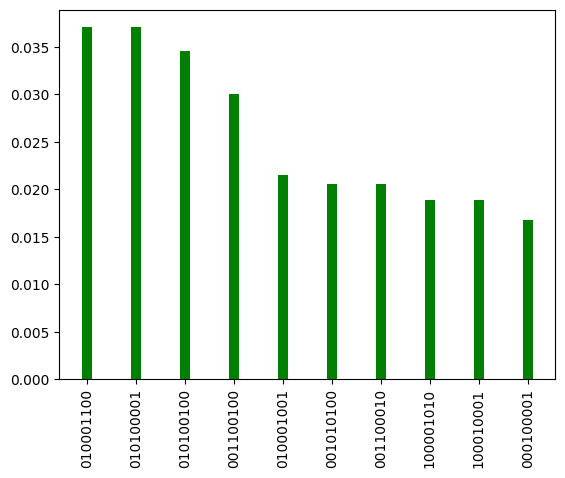

In [11]:
def solve_qaoa():
	initial_params = np.random.uniform(0.0, 2*np.pi, size=2*p)
	hamiltonians = (prepare_cost(), prepare_driver())
	optimal = minimize(objective, initial_params, hamiltonians, method='Nelder-Mead')
	angles = optimal.x
	gammas = angles[0:p]
	betas = angles[p:2*p]
	soln = parameterized_quantum_state(*hamiltonians, gammas, betas)
	prob_dict = sim.wavefunction(soln).get_outcome_probs()
	sorted_strings = []
	sorted_counts = []
	for key, value in sorted(prob_dict.items(), key=second, reverse=True):
		sorted_strings.append(key)
		sorted_counts.append(value)
	length = len(sorted_strings)
	if length > 10:
		length = 10
		sorted_strings = sorted_strings[:10]
		sorted_counts = sorted_counts[:10]
	width = 2/length
	plt.bar(sorted_strings, sorted_counts, width, color='g')
	plt.xticks(rotation=90)
	print(sorted_strings)
	print(sorted_counts)
	plt.show()

solve_qaoa()